This is the classification based E-commerce text dataset for 4 categories - "Electronics", "Household", "Books" and "Clothing & Accessories", which almost cover 80% of any E-commerce website.

https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification


## Installation of Kaggle, Wandb and Transformers

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install wandb
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=010a4190494a73f3d18ec066f670c96e7b01a9ae9a8cd98aea2a4e412875a479
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size

In [30]:
import os
import re
import json
import wandb
import spacy
import pickle
import logging
import zipfile
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_metric

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import layers
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

In [3]:
os.mkdir('/content/kaggle')

In [7]:
token = {"username" : "prabhatale", "key" : "847b0547dfa44b477a7807fb0e9e9de8"}
with open('/content/kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [8]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle config set -n path -v /content

- path is now set to: /content


In [10]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d saurabhshahane/ecommerce-text-classification -p /content

 89% 7.00M/7.86M [00:00<00:00, 73.1MB/s]
100% 7.86M/7.86M [00:00<00:00, 80.2MB/s]


In [12]:
archive = zipfile.ZipFile('ecommerce-text-classification.zip')
archive.extractall('/content')

In [13]:
df = pd.read_csv('ecommerceDataset.csv',
                 header = None,
                 names = ["product_type", "description"])
print(df.shape)
df.head()

(50425, 2)


,product_type,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [14]:
df['description'][0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

## Checking Null Values


In [15]:
df.isnull().sum()

product_type    0
description     1
dtype: int64

## Dropping rows having null values

In [16]:
df = df.dropna(subset=['description'])

In [17]:
df.isnull().sum()

product_type    0
description     0
dtype: int64

### Checking the target column

In [18]:
product_stats = df['product_type'].value_counts().to_frame().reset_index(drop = False)
product_stats.columns = ["product_type", "frequency"]
product_stats.head()

,product_type,frequency
0,Household,19313
1,Books,11820
2,Electronics,10621
3,Clothing & Accessories,8670


## Visualize the target labels

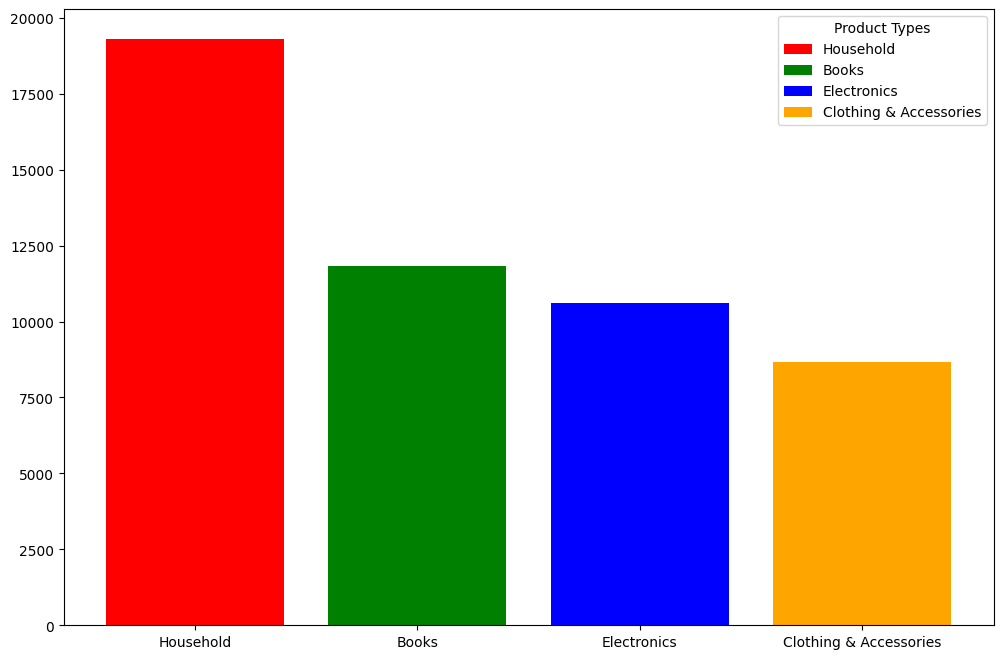

In [19]:
# Your data and plot setup
fig = plt.figure(figsize=(12, 8))
plt.bar(x=product_stats["product_type"],
        height=product_stats["frequency"],
        color=["red", "green", "blue", "orange"],
        label = product_stats["product_type"])
plt.legend(product_stats["product_type"], title="Product Types")


## Text Preprocessing

In [20]:
nlp = spacy.load("en_core_web_sm")

In [21]:
def remove_punctuation(text):
    doc = nlp(text)
    cleaned_text = ' '.join(token.text for token in doc if not token.is_punct)
    return cleaned_text


In [22]:
def remove_stopwords(text):
    doc = nlp(text)
    cleaned_text = ' '.join(token.text for token in doc if not token.is_stop)
    return cleaned_text


In [23]:
def clean_text(text):
    doc = nlp(text)
    cleaned_text = ' '.join(token.text.lower() for token in doc if not token.is_digit)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text


In [24]:
# df['clean_description'] = df['description'].apply(remove_punctuation)

In [25]:
df['clean_description'] = df['description'].apply(clean_text)

In [26]:
df['clean_description'] = df['clean_description'].apply(remove_stopwords)

In [27]:
df['clean_description']

0        paper plane design framed wall hanging motivat...
1        saf ' floral ' framed painting ( wood , inch x...
2        saf ' uv textured modern art print framed ' pa...
3        saf flower print framed painting ( synthetic ,...
4        incredible gifts india wooden happy birthday u...
                               ...                        
50420    strontium microsd class gb memory card ( black...
50421    crossbeats wave waterproof bluetooth wireless ...
50422    karbonn titanium wind w4 ( white ) karbonn tit...
50423    samsung guru fm plus ( sm - b110e / d , black ...
50424                   micromax canvas win w121 ( white )
Name: clean_description, Length: 50424, dtype: object

## Label Encoding a Target Column

In [28]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['encoded_product_type'] = label_encoder.fit_transform(df['product_type'])


In [32]:
# Store data in a pickle file
with open("ecommerce_product_classification_label_encoder.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

In [33]:
df.head()

,product_type,description,clean_description,encoded_product_type
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...,3
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...","saf ' floral ' framed painting ( wood , inch x...",3
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf ' uv textured modern art print framed ' pa...,3
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...","saf flower print framed painting ( synthetic ,...",3
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...,3


In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
df.to_csv('ecommerce_product_classification.csv', index=False)

In [36]:
!cp -r "/content/ecommerce_product_classification.csv" "/content/gdrive/MyDrive/NLP/Ecommerce_Product_Classification/preprocessed_data"
!cp -r "/content/ecommerce_product_classification_label_encoder.pkl" "/content/gdrive/MyDrive/NLP/Ecommerce_Product_Classification/label_encoder"